# Predicting Fraudulent Transactions

In this notebook we will take fraud data, resample it and make comparisons between the fraud detector trained with over sampled data to the one trained with no over sampling.

Data is taken from Kaggle:
The dataset has been collected and analysed during a research collaboration of Worldline and the Machine Learning Group (http://mlg.ulb.ac.be) of ULB (Université Libre de Bruxelles) on big data mining and fraud detection.


In [1]:
# Import the required modules
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression


# Prepare the Data

### Step 1: Load the `transaction_fraud_data.csv` file from the `Resources` folder into a Pandas DataFrame. Set the “id” column as the index.

In [3]:
# Read in the transaction_fraud_data.csv file into a PandasDataFrame.
transaction_fraud_data = pd.read_csv(
    Path("./creditcard.csv"), 
)

# Review the DataFrame
transaction_fraud_data.head()


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Most of the features have already been engineered and normalized for this dataset. The 'Amount' column still needs to be normalized.

In [27]:
# make copy for manipulation
fraud_df = transaction_fraud_data.copy()

# replace Amount with normalized amount
fraud_df["amount_norm"] = (fraud_df["Amount"] - fraud_df["Amount"].mean()) / fraud_df["Amount"].std()

# drop original amount and time columns as they are not usfeul
fraud_df.drop(columns=["Amount", "Time"], inplace=True)

fraud_df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Class,amount_norm
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,0.244964
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.342474
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,1.160684
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,0.140534
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,-0.073403


### Show how many of each class of fraud there is to see if we need to balance the dataset 

In [28]:
# The  column 'fraud' is the thing you want to predict. 
# Class 0 indicates no-fraud trasactions and class 1 indicates fraudulent transactions
# Using value_counts, how many fraudulent transactions are in this dataset?
fraud_df["Class"].value_counts()

0    284315
1       492
Name: Class, dtype: int64

As we can see there are very few cases of fraud. This tells us it is a very imabalanced dataset and we need to perform a resampling.

# Split the data into training and testing sets

In [29]:
# The target column should be the binary `fraud` column.
target = fraud_df["Class"]


# The features column should be all of the features. 
features = fraud_df.drop(columns=["Class"])

In [30]:
features.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,amount_norm
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0.244964
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,-0.342474
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,1.160684
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0.140534
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,-0.073403


### Step 2: Split the features and target data into `training_features`, `testing_features`, `training_targets`, and `testing_targets` datasets by using the `train_test_split` function.

In [31]:
# Split the dataset using the train_test_split function with a 30% testing size and 70% training size
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3)

### Oversample the data to get a more balanced data set

In [32]:
# Resample the data which we will compare later
random_oversampler = RandomOverSampler(random_state=1)
X_resampled, y_resampled = random_oversampler.fit_resample(X_train, y_train)

# Count the distinct values to show a rebalanced dataset
y_resampled.value_counts()

0    199021
1    199021
Name: Class, dtype: int64

Now we can see that the training set has a balanced number of fraudelent events and none fraudulent events

# Model and Fit the Data to a Logistic Regression

In [33]:
# Declare 2 logistic regression models for over sampled and not oversampled data
# Apply a random_state of 7 to the model
lr_norm = LogisticRegression(random_state=7)
lr_over_samp = LogisticRegression(random_state=7)

### Step 2: Fit the training data to the model, and save the model.

In [34]:
# Fit and save the logistic regression model using the training data for both training sets
lr_norm = lr_norm.fit(X_train, y_train)
lr_over_samp = lr_over_samp.fit(X_resampled, y_resampled)

# Predict both normal and over sampled data

In [35]:
# Make and save testing predictions with the saved logistic regression model using the test data
pred_norm = lr_norm.predict(X_test)
pred_over_samp = lr_over_samp.predict(X_test)

# Calculate the Performance Metrics

In [36]:
# Display the accuracy score for the test dataset.
accuracy_norm = accuracy_score(y_test, pred_norm)
accuracy_over = accuracy_score(y_test, pred_over_samp)

In [37]:
print(f"The accuracy of our regression model that was trained with the normal data is {accuracy_norm}")
print(f"The accuracy of our regression model that was trained with over sampled data is {accuracy_over}")

The accuracy of our regression model that was trained with the normal data is 0.9992275552122467
The accuracy of our regression model that was trained with over sampled data is 0.9744039886239949


This is an interesting finding. The accuracy of the regular dataset was higher than the oversampled dataset in this case. There may have been a sufficient number of samples in the regular dataset that oversampling was unecessary and actually harmed our model's performance. 

# Fit a decision tree and find the most important feature

In [38]:
from sklearn.tree import DecisionTreeClassifier

# create tree instance with default parameters
tree = DecisionTreeClassifier()
# fit tree to data
tree.fit(X_train, y_train)
# make predictions
tree_pred = tree.predict(X_test)
# get accuracy 
tree_accuracy = accuracy_score(y_test, tree_pred)
print(f"The accuracy of the tree is {tree_accuracy}")

The accuracy of the tree is 0.999204147794436


# Observe feature importance

<Axes: xlabel='importance', ylabel='feature'>

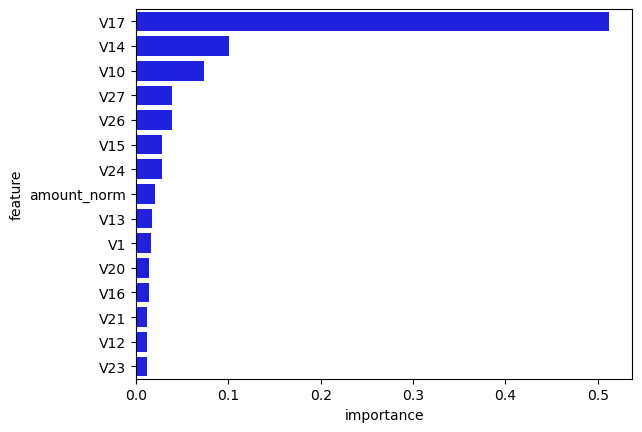

In [39]:
import seaborn as sns
# get columns names
col_names_full = list(X_train.columns)
df_var_imp = pd.DataFrame({"feature": col_names_full, 
                           "importance": tree.feature_importances_})
df_var_imp.sort_values(by="importance", ascending=False, inplace=True)

sns.barplot(x="importance", y="feature", data=df_var_imp.head(15), color="blue")

I was going to assume that amount would have a higher feature importance when detecting fraud, but it looks like the V17 feature is just about the most important feature. Unfortunately, this dataset did not have any of the actual information associated with the columns. It could be due to sensitive information or that these columns were acquired from principal component analysis and don't have actual names.  